In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from time import ctime
from math import sqrt
from math import log
from math import exp
from scipy.stats import norm
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [2]:
# fit function: exponential function with constant background
def fitfunc(x,a,b,c):
    return a*np.exp(-x/b) + c

# fit for a guass
def fitgaus(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

In [22]:
# LOAD DATA
arr = np.loadtxt("6 day data collection run.data")
raw_dt     = arr[:,0]
raw_t_abs  = arr[:,1]

# convert absolute times to something human readable
times = [ctime(t) for t in raw_t_abs]

# select muon events
muon_dt = raw_dt[raw_dt<40000]                 #filters out failed timings
muon_dt_micros = [t/1000. for t in muon_dt]    #converts to us
muon_dt_micros=np.array(muon_dt_micros)
muon_dt_micros = muon_dt_micros[muon_dt_micros>0.2] 
muon_dt_micros = muon_dt_micros[muon_dt_micros<19] 

In [23]:
#Histogram the now filtered data
plt.figure(1)
bin_num1 = 100
n,bins,patches = plt.hist(muon_dt_micros, bin_num1, histtype='stepfilled')
plt.close(1)
#calculates bin centers from bin edges
bincenters = [t+(bins[1]-bins[0])/2. for t in bins]
#calculates converts the positions, heights and errors into arrays 
x = np.asarray(bincenters[0:len(n)])
y = n
ey = [sqrt(z) for z in y]
weights = []
#Sets the correct weights, avoiding div0 errors
for s in ey:
    if s > 0:
        weights.append(1./(s))
    else:
        weights.append(0.)
print(bincenters)

[0.3136, 0.5008, 0.6880000000000001, 0.8752000000000001, 1.0624, 1.2496, 1.4368, 1.624, 1.8112000000000001, 1.9984000000000002, 2.1856000000000004, 2.3728000000000007, 2.5600000000000005, 2.7472000000000003, 2.9344000000000006, 3.121600000000001, 3.3088000000000006, 3.4960000000000004, 3.6832000000000007, 3.870400000000001, 4.057600000000001, 4.244800000000001, 4.432000000000001, 4.619200000000001, 4.806400000000001, 4.993600000000001, 5.1808000000000005, 5.368000000000001, 5.555200000000001, 5.742400000000001, 5.9296000000000015, 6.116800000000001, 6.304000000000001, 6.491200000000001, 6.678400000000001, 6.8656000000000015, 7.052800000000001, 7.240000000000001, 7.427200000000002, 7.614400000000002, 7.801600000000001, 7.988800000000001, 8.176000000000002, 8.363200000000003, 8.550400000000003, 8.737600000000002, 8.924800000000003, 9.112000000000002, 9.299200000000003, 9.486400000000003, 9.673600000000002, 9.860800000000003, 10.048000000000002, 10.235200000000003, 10.422400000000003, 10.

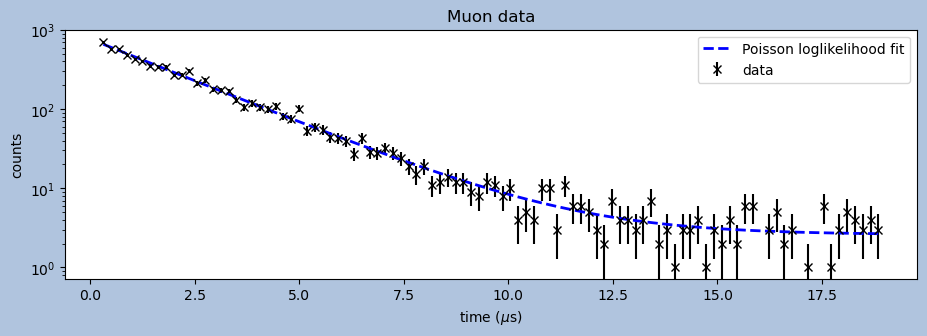

In [24]:
# Some vaguely reasonable initial guesses
temp = np.array(y)
start_values = [max(y),np.average(x,weights=y),min(temp[temp>0])]

# Start plot
plt.figure(figsize = (11,11), facecolor = 'LightSteelBlue', )
ax = plt.subplot(311)

# Plot data
plt.errorbar(x,y,ey,c='black',fmt='x',label='data')
plt.title("Muon data")    
plt.ylabel('counts')
plt.xlabel('time ($\\mu$s)')
plt.yscale('log')            #plots on a logarithmic scale

# Standard chi^2 fit to dat
parnames = ['scale','decay time','background']
parunits = ["counts/1 $\\mu$s","$\\mu$s","counts/1 $\\mu$s"]
#returns the fitted parameters and covariance matrix for a gaussian fit
#p_opt, p_cov = curve_fit(fitfunc,x,y,start_values)
#plots the fitted function with the found parameters
#plt.plot(x,fitfunc(x,*p_opt),'r--', linewidth=2,label='$\\chi^2$ fit')
#produces a nice output of all the relevant fit variables
#print('\n\n====== STANDARD CHISQUARED FIT ======\n')
#chi_squared = 0.
#calculates the contribution to the chi-squared from each point individually.
#for i, (ix,iy,iey) in enumerate(zip(x,y,ey)):
#    if iy > 0:
#        chi_squared += ((fitfunc(ix, *p_opt)-iy)/iey)**2
#use dof to find reduced chi squared
#ndf =  len(x)-len(p_opt)
#reduced_chi_squared = chi_squared/ndf
#use scipy probability function to find the probability
#prob = chi2.sf(chi_squared,ndf)
#print('The degrees of freedom for this test is',ndf)
#print('The chi squared value is: ',("%.2f" %chi_squared))
#print('The reduced chi squared value is: ',("%.2f" %reduced_chi_squared))
#print('The probability is : ', ("%5.2f" % prob))
#calculates the errors on the fitted parameters using the covariance matrix
#errors = np.sqrt(np.diag(p_cov))
#for i,(value,error) in enumerate(zip(p_opt,errors)):
#    print(("%10s"%parnames[i]),': ',("%.3f"%value),' +/- ',("%.3f"%error),("%s"%parunits[i]))
    
# Poisson based log-likelihood fit
# (see handout 'Statistical analysis of data')
# assumes array x contains the values of bin centers, 
#         array y contains the values of bin contents
def loglikelihood(par):
    #calculates the contribution to the log likelihood from each point individually
    #negative because computers prefer minimizing
    ll = 0.
    for i,t in enumerate(x):
        mu  = fitfunc(t,par[0],par[1],par[2])
        ll += mu-y[i]*log(mu)
    return 2.*ll   
#minimize the log likelihood (equivalent to maximizing poisson probability)
res=minimize(loglikelihood,start_values)
#makes a pretty plot
plt.plot(x,fitfunc(x,*res.x),'b--', linewidth=2,label='Poisson loglikelihood fit')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

In [25]:
print('\n\n====== POISSON LIKELIHOOD FIT ======\n')
print('Minimum likelihood: ',("%0f"%loglikelihood(res.x)))
    
# estimate error for all three parameters
#sets the starting points of our error finder
parmin = list(res.x)
parmax = list(res.x)
#repeats process for each fitted parameter
for parnr in [0,1,2]:
    #printing some details
    par = list(res.x)
    print('Estimating uncertainties for ',("%s"%parnames[parnr]),':')
    #log likelyhood for our starting point
    lfit = loglikelihood(par)
    # neg side
    lmin = lfit
    xmin = par[parnr]
    #calculate log likelyhood at small steps further from the minimum until log likelyhood increases by one.
    while lmin < lfit+1.:
        par[parnr] -= res.x[parnr]/10000.
        lmin = loglikelihood(par)
    parmin[parnr] = par[parnr]
    print('min value ',("%.2f"%parmin[parnr]),' at likelihood ',("%0f"%lmin))
    # pos side
    #repeats the process for the upper error
    lmax = lfit
    par = list(res.x)
    xmax = par[1]
    while lmax < lfit+1:
        par[parnr] += res.x[parnr]/10000.
        lmax = loglikelihood(par)
    parmax[parnr] = par[parnr]
    print('max value ',("%.2f"%parmax[parnr]),' at likelihood ',("%0f"%lmax))
    #calcautes and prints the upper and lower error.
for i,value in enumerate(res.x):
    print(("%10s"%parnames[i]),': ',("%6.3f"%value),
           '+',("%.3f"%(parmax[i]-res.x[i])),
           '-',("%.3f"%(res.x[i]-parmin[i])),("%s"%parunits[i]))



====== POISSON LIKELIHOOD FIT ======

Minimum likelihood:  -69469.700260
Estimating uncertainties for  scale :
min value  756.47  at likelihood  -69468.699787
max value  774.38  at likelihood  -69468.685336
Estimating uncertainties for  decay time :
min value  2.03  at likelihood  -69468.694043
max value  2.07  at likelihood  -69468.684421
Estimating uncertainties for  background :
min value  2.34  at likelihood  -69468.698591
max value  2.85  at likelihood  -69468.699228
     scale :  765.345 + 9.031 - 8.878 counts/1 $\mu$s
decay time :   2.048 + 0.017 - 0.017 $\mu$s
background :   2.589 + 0.262 - 0.249 counts/1 $\mu$s


[ 1.53880092 -1.25145785  0.85515446 -0.85581447 -1.26084469 -0.76773329
 -1.71548366 -0.43037939  1.31228185 -1.41026967  0.43035164  3.40125277
 -0.7506764   1.79687633 -0.54467494  0.20498651  0.94793882 -0.91390029
 -2.37445786 -0.02404608 -0.30821892  0.0062515   1.76981197 -0.20471473
  0.01915167  3.14074992 -1.45566548  0.09518225  0.21496521 -0.74886504
 -0.292293   -0.3554479  -2.08726407  1.25561161 -0.54891882 -0.26289212
  0.87501046  0.58324663  0.21149229 -0.50112648 -1.17744965  0.21152635
 -1.72620539 -1.00762872 -0.09720725 -0.38547399 -0.11453097 -0.84671625
 -0.9752299   0.56439849  0.4843226  -0.28262208  0.55119269 -1.88097459
 -1.0331344  -1.44891408  1.09999483  1.20860305 -1.65388304  1.63463334
  0.27865164  0.37593112  0.06185522 -0.96025404 -1.75508526  1.01417574
 -0.08293021 -0.01407795 -0.52104628  0.10611094  1.25367199 -1.12257182
 -0.2888838  -2.42078222 -0.20100655 -0.16273676  0.38931373 -2.16616051
 -0.06684028 -0.75645017  0.48609495 -0.69968499  1

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_29792\1269741004.py:5: RuntimeWarning: divide by zero encountered in divide
  pull_ll = r_ll / ey


 20
*** Pull distribution Poisson likelihood
  constant :  3.397  +/-  0.497 counts
      mean :  -0.286  +/-  0.197 $\mu$s
     sigma :  1.159  +/-  0.208 $\mu$s
*** Pull distribution Poisson likelihood
  constant :  22.455  +/-  0.543 counts
      mean :  -0.384  +/-  0.024 $\mu$s
     sigma :  2.532  +/-  0.072 $\mu$s


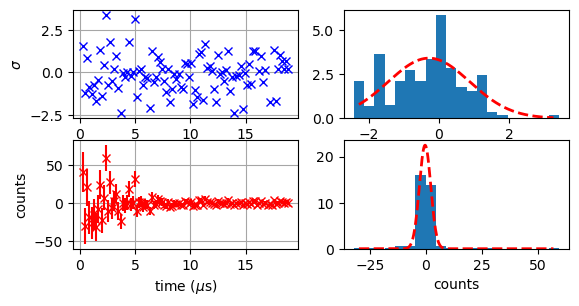

In [26]:
# pull poisson
plt.subplot(323)
#calculates distant of data from poisson fit. converts to sigma
r_ll = y - fitfunc(x,*res.x)
pull_ll = r_ll / ey
condition = pull_ll != -np.inf
weights=np.array(weights)
# Filtered array
pull_ll = pull_ll[condition]
xfilt = x[condition]
#plots the calculated pulls
plt.errorbar(xfilt,pull_ll,c='blue',fmt='x',label='loglikelihood residual')   
plt.ylabel('$\\sigma$')
plt.xlabel('time ($\\mu$s)')
plt.grid(visible=True, which='both', color='0.65',linestyle='-')

# residuals loglikelihood
plt.subplot(325)
#calculates distant of data from Poisson fit
r_ll = y - fitfunc(x,*res.x)
plt.errorbar(x,r_ll,ey,c='red',fmt='x',label='loglikelihood residual')   
plt.ylabel('counts')
plt.xlabel('time ($\\mu$s)')
plt.grid(visible=True, which='both', color='0.65',linestyle='-')
bin_num2 = 20
# gaussian fit (with histogram) for chisquared
plt.subplot(324)
#histogram our calculated pulls
print(pull_ll,bin_num2)
(n_ll,bins_ll) = np.histogram(pull_ll,bin_num2,weights=weights[condition])
(mu_ll, sigma_ll) = norm.fit(pull_ll)
start_ll = [max(n_ll),np.average(pull_ll),sigma_ll]
bincenters_ll = [t_ll+(bins_ll[1]-bins_ll[0])/2. for t_ll in bins_ll]
x_ll = np.asarray(bincenters_ll[0:len(bincenters_ll)-1])
#plot the histogram
plt.bar(x_ll,n_ll,width=((x_ll[-1]-x_ll[0])/(bin_num2-1)))
plt.xlabel('time ($\\mu$s)')
#fits a gaussian to our pulls
p_opt_ll, p_cov_ll = curve_fit(fitgaus,x_ll,n_ll,start_ll)
x_ll2 = np.arange(min(x_ll),max(x_ll),(max(x_ll)-min(x_ll))/1000)
#plots our nicely fitted gaussian
plt.plot(x_ll2,fitgaus(x_ll2,*p_opt_ll),'r--', linewidth=2)
#prints the fitted parameters of our gaussian
print('*** Pull distribution Poisson likelihood')
parnames_ll = ['constant','mean','sigma']
parunits_ll = ['counts','$\\mu$s','$\\mu$s']
errors_ll = np.sqrt(np.diag(p_cov_ll))
for i,(value,error) in enumerate(zip(p_opt_ll,errors_ll)):
    print(("%10s"%parnames_ll[i]),': ',("%.3f"%value),' +/- ',("%.3f"%error),("%s"%parunits_ll[i]))

# gaussian fit (with histogram) for poisson
plt.subplot(326)
#histogram our calculated residuals
(n_ll,bins_ll) = np.histogram(r_ll,bin_num2,weights=weights)
(mu_ll, sigma_ll) = norm.fit(r_ll)
start_ll = [max(n_ll),np.average(r_ll),sigma_ll]
bincenters_ll = [t_ll+(bins_ll[1]-bins_ll[0])/2. for t_ll in bins_ll]
x_ll = np.asarray(bincenters_ll[0:len(bincenters_ll)-1])
#plot the histogram
plt.bar(x_ll,n_ll,width=((x_ll[-1]-x_ll[0])/(bin_num2-1)))
plt.xlabel('counts')
#fits a gaussian to our residuals
p_opt_ll, p_cov_ll = curve_fit(fitgaus,x_ll,n_ll,start_ll)
x_ll2 = np.arange(min(x_ll),max(x_ll),(max(x_ll)-min(x_ll))/1000)
#plots our nicely fitted gaussian
plt.plot(x_ll2,fitgaus(x_ll2,*p_opt_ll),'r--', linewidth=2)
#prints the fitted parameters of our gaussian
print('*** Pull distribution Poisson likelihood')
parnames_ll = ['constant','mean','sigma']
parunits_ll = ['counts','$\\mu$s','$\\mu$s']
errors_ll = np.sqrt(np.diag(p_cov_ll))
for i,(value,error) in enumerate(zip(p_opt_ll,errors_ll)):
    print(("%10s"%parnames_ll[i]),': ',("%.3f"%value),' +/- ',("%.3f"%error),("%s"%parunits_ll[i]))

NameError: name 'p_opt' is not defined

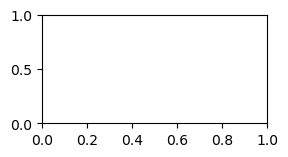

In [27]:
# residuals chisquared
plt.subplot(323)
r_chi = y - fitfunc(x,*p_opt)
plt.errorbar(x,r_chi,ey,c='red',fmt='x',label='$\\chi^2$ residual')   
plt.ylabel('counts')
plt.xlabel('time ($\\mu$s)')
plt.grid(visible=True, which='both', color='0.65',linestyle='-')
# gaussian fit (with histogram) for chisquared
plt.subplot(324)
bin_num2 = 20
(n_chi,bins_chi) = np.histogram(r_chi,bin_num2,weights=weights)
(mu_chi, sigma_chi) = norm.fit(r_chi)
start_chi = [max(n_chi),mu_chi,sigma_chi]
bincenters_chi = [t_chi+(bins_chi[1]-bins_chi[0])/2. for t_chi in bins_chi]
x_chi = np.asarray(bincenters_chi[0:len(bincenters_chi)-1])
plt.bar(x_chi,n_chi,width=((x_chi[-1]-x_chi[0])/(bin_num2-1)))
plt.xlabel('time ($\\mu$s)')
p_opt_chi, p_cov_chi = curve_fit(fitgaus,x_chi,n_chi,start_chi)
x_chi2 = np.arange(min(x_chi),max(x_chi),(max(x_chi)-min(x_chi))/1000)
plt.plot(x_chi2,fitgaus(x_chi2,*p_opt_chi),'r--', linewidth=2)
print('*** Pull distribution $\\chi^2$:')
parnames_chi = ['constant','mean','sigma']
parunits_chi = ['counts','$\\mu$s','$\\mu$s']
errors_chi = np.sqrt(np.diag(p_cov_chi))
for i,(value,error) in enumerate(zip(p_opt_chi,errors_chi)):
    print(("%10s"%parnames_chi[i]),': ',("%.3f"%value),' +/- ',("%.3f"%error),("%s"%parunits_chi[i]))
plt.subplot(325)
#calculates distant of data from Poisson fit
r_ll = y - fitfunc(x,*res.x)
plt.errorbar(x,r_ll,ey,c='blue',fmt='x',label='loglikelihood residual')   
plt.ylabel('counts')
plt.xlabel('time ($\\mu$s)')
plt.grid(visible=True, which='both', color='0.65',linestyle='-')
bin_num2 = 10
# gaussian fit (with histogram) for poisson
plt.subplot(326)
(n_ll,bins_ll) = np.histogram(r_ll,bin_num2,weights=weights)
(mu_ll, sigma_ll) = norm.fit(r_ll)
start_ll = [max(n_ll),np.average(r_ll),sigma_ll]
bincenters_ll = [t_ll+(bins_ll[1]-bins_ll[0])/2. for t_ll in bins_ll]
x_ll = np.asarray(bincenters_ll[0:len(bincenters_ll)-1])
plt.bar(x_ll,n_ll,width=((x_ll[-1]-x_ll[0])/(bin_num2-1)))
plt.xlabel('time ($\\mu$s)')
p_opt_ll, p_cov_ll = curve_fit(fitgaus,x_ll,n_ll,start_ll)
x_ll2 = np.arange(min(x_ll),max(x_ll),(max(x_ll)-min(x_ll))/1000)
plt.plot(x_ll2,fitgaus(x_ll2,*p_opt_ll),'r--', linewidth=2)
print('*** Pull distribution Poisson likelihood')
parnames_ll = ['constant','mean','sigma']
parunits_ll = ['counts','$\\mu$s','$\\mu$s']
errors_ll = np.sqrt(np.diag(p_cov_ll))
for i,(value,error) in enumerate(zip(p_opt_ll,errors_ll)):
    print(("%10s"%parnames_chi[i]),': ',("%.3f"%value),' +/- ',("%.3f"%error),("%s"%parunits_chi[i]))

In [ ]:
# pull poisson
plt.subplot(325)
#calculates distant of data from poisson fit. converts to sigma
r_ll = y - fitfunc(x,*res.x)
pull_ll = r_ll / ey
#plots the calculated pulls
plt.errorbar(x,pull_ll,c='blue',fmt='x',label='loglikelihood residual')   
plt.ylabel('$\\sigma$')
plt.xlabel('time ($\\mu$s)')
plt.grid(visible=True, which='both', color='0.65',linestyle='-')
#histogram our calculated pulls
# gaussian fit (with histogram) for chisquared
# pull chisquared
plt.subplot(323)
r_chi = y - fitfunc(x,*p_opt)
pull_chi = r_chi / ey
plt.errorbar(x,pull_chi,c='red',fmt='x',label='$\chi^2$ residual') 
plt.ylabel('$\\sigma$')
plt.xlabel('time ($\mu$s)')
plt.grid(visible=True, which='both', color='0.65',linestyle='-')
plt.subplot(324)
bin_num2 = 20
(n_chi,bins_chi) = np.histogram(r_chi,bin_num2,weights=weights)
(mu_chi, sigma_chi) = norm.fit(r_chi)
start_chi = [max(n_chi),mu_chi,sigma_chi]
bincenters_chi = [t_chi+(bins_chi[1]-bins_chi[0])/2. for t_chi in bins_chi]
x_chi = np.asarray(bincenters_chi[0:len(bincenters_chi)-1])
plt.bar(x_chi,n_chi,width=((x_chi[-1]-x_chi[0])/(bin_num2-1)))
plt.xlabel('time ($\mu$s)')
p_opt_chi, p_cov_chi = curve_fit(fitgaus,x_chi,n_chi,start_chi)
x_chi2 = np.arange(min(x_chi),max(x_chi),(max(x_chi)-min(x_chi))/1000)
plt.plot(x_chi2,fitgaus(x_chi2,*p_opt_chi),'r--', linewidth=2)
print('*** Pull distribution $\chi^2$:')
parnames_chi = ['constant','mean','sigma']
parunits_chi = ['counts','$\mu$s','$\mu$s']
errors_chi = np.sqrt(np.diag(p_cov_chi))
for i,(value,error) in enumerate(zip(p_opt_chi,errors_chi)):
    print(("%10s"%parnames_chi[i]),': ',("%.3f"%value),' +/- ',("%.3f"%error),("%s"%parunits_chi[i]))
plt.subplot(326)
print(pull_ll,bin_num2)
(n_ll,bins_ll) = np.histogram(pull_ll,bin_num2,weights=weights)
(mu_ll, sigma_ll) = norm.fit(pull_ll)
start_ll = [max(n_ll),np.average(pull_ll),sigma_ll]
bincenters_ll = [t_ll+(bins_ll[1]-bins_ll[0])/2. for t_ll in bins_ll]
x_ll = np.asarray(bincenters_ll[0:len(bincenters_ll)-1])
#plot the histogram
plt.bar(x_ll,n_ll,width=((x_ll[-1]-x_ll[0])/(bin_num2-1)))
plt.xlabel('time ($\\mu$s)')
#fits a gaussian to our pulls
p_opt_ll, p_cov_ll = curve_fit(fitgaus,x_ll,n_ll,start_ll)
x_ll2 = np.arange(min(x_ll),max(x_ll),(max(x_ll)-min(x_ll))/1000)
#plots our nicely fitted gaussian
plt.plot(x_ll2,fitgaus(x_ll2,*p_opt_ll),'r--', linewidth=2)
#prints the fitted parameters of our gaussian
print('*** Pull distribution Poisson likelihood')
parnames_ll = ['constant','mean','sigma']
parunits_ll = ['counts','$\\mu$s','$\\mu$s']
errors_ll = np.sqrt(np.diag(p_cov_ll))
for i,(value,error) in enumerate(zip(p_opt_ll,errors_ll)):
    print(("%10s"%parnames_ll[i]),': ',("%.3f"%value),' +/- ',("%.3f"%error),("%s"%parunits_ll[i]))